In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
data = pd.read_csv('heart_problems.csv')

In [3]:
data = data.rename(columns={'DEATH_EVENT': 'HEART_DISEASE'})
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,HEART_DISEASE
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
missing_values = data.isnull().sum()
print("Пропущені значення:\n", missing_values)

Пропущені значення:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
HEART_DISEASE               0
dtype: int64


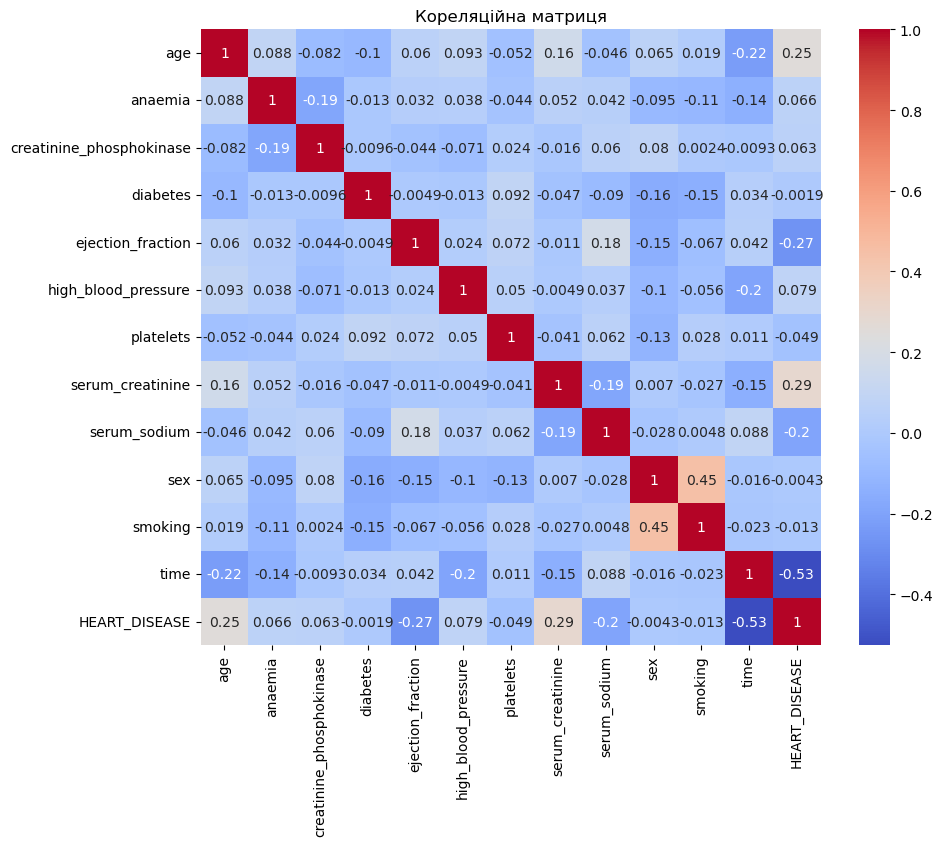

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Кореляційна матриця")
plt.show()

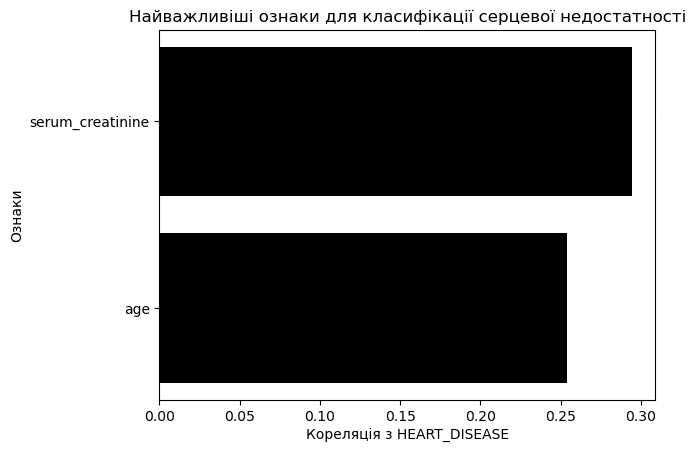

In [5]:
correlations = data.drop("HEART_DISEASE", axis=1).corrwith(data["HEART_DISEASE"]).sort_values()
top_features = correlations.tail(2)
plt.barh(top_features.index, top_features.values, color="black")
plt.title("Найважливіші ознаки для класифікації серцевої недостатності")
plt.xlabel("Кореляція з HEART_DISEASE")
plt.ylabel("Ознаки")
for i, v in enumerate(top_features):
    plt.text(v, i, str(round(v,2)) + '%', color='white', fontweight='bold', ha='left', va='center')
plt.show()

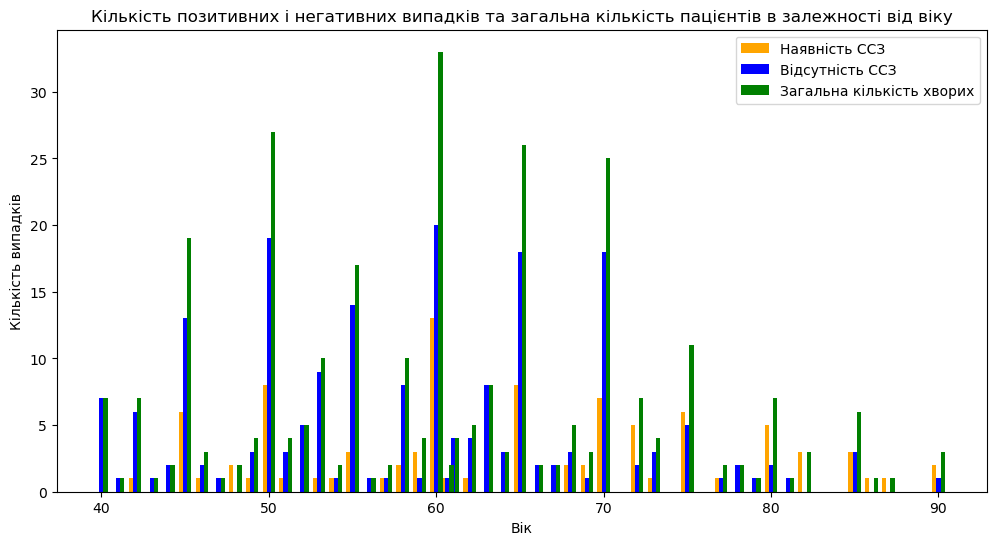

In [7]:
filtered_data = data[(data['age'] >= 20) & (data['age'] <= 90)]
age_count = filtered_data['age'].value_counts().sort_index()
age_death_count = filtered_data[filtered_data['HEART_DISEASE'] == 1]['age'].value_counts().sort_index()
age_survival_count = filtered_data[filtered_data['HEART_DISEASE'] == 0]['age'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25
ax.bar(age_death_count.index - width, age_death_count.values, width, color='orange', label='Наявність ССЗ')
ax.bar(age_survival_count.index, age_survival_count.values, width, color='blue', label='Відсутність ССЗ')
ax.bar(age_count.index + width, age_count.values, width, color='green', label='Загальна кількість хворих')
ax.set_xlabel('Вік')
ax.set_ylabel('Кількість випадків')
ax.set_title('Кількість позитивних і негативних випадків та загальна кількість пацієнтів в залежності від віку')
ax.legend()

plt.show()

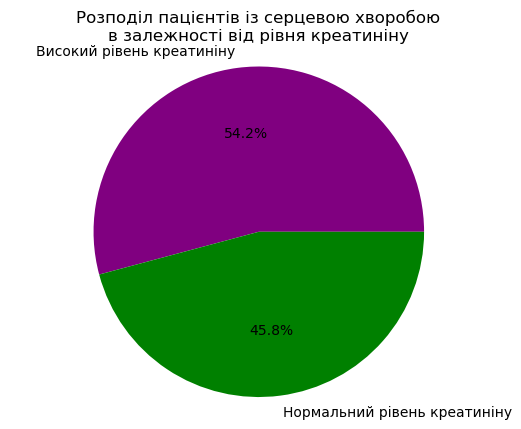

In [8]:
creatinine_upper_limit_male = 1.3
creatinine_upper_limit_female = 1.1
high_creatinine = data[(data['HEART_DISEASE'] == 1) & (((data['serum_creatinine'] > creatinine_upper_limit_male) & (data['sex'] == 1)) | ((data['serum_creatinine'] > creatinine_upper_limit_female) & (data['sex'] == 0)))]
normal_creatinine = data[(data['HEART_DISEASE'] == 1) & (((data['serum_creatinine'] <= creatinine_upper_limit_male) & (data['sex'] == 1)) | ((data['serum_creatinine'] <= creatinine_upper_limit_female) & (data['sex'] == 0)))]
death_counts = [len(high_creatinine), len(normal_creatinine)]
labels = ['Високий рівень креатиніну', 'Нормальний рівень креатиніну']
colors = ['purple', 'green']
plt.pie(death_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Розподіл пацієнтів із серцевою хворобою\nв залежності від рівня креатиніну')
plt.show()

In [9]:
duplicates = data.duplicated().sum()
print("\nДублікати:", duplicates)


Дублікати: 0


In [10]:
threshold = 3
z_scores = (data - data.mean()) / data.std()
outliers_z_scores = (z_scores > threshold).any(axis=1)
anomalies_z_scores = data[outliers_z_scores]

print("Аномалії за допомогою з-оцінок:")
print(anomalies_z_scores)

Аномалії за допомогою з-оцінок:
      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
1    55.0        0                      7861         0                 38   
9    80.0        1                       123         0                 35   
28   58.0        1                        60         0                 38   
52   60.0        0                      3964         1                 62   
60   45.0        0                      7702         1                 25   
64   45.0        0                       582         0                 80   
72   85.0        0                      5882         0                 35   
103  42.0        0                      5209         0                 30   
105  72.0        1                       328         0                 30   
109  45.0        0                       292         1                 35   
131  60.0        1                      1082         1                 45   
134  81.0        0                      4540

In [11]:
num_outliers = outliers_z_scores.sum()
print(f"Кількість аномалій, виявлених за допомогою z-score: {num_outliers}")

Кількість аномалій, виявлених за допомогою z-score: 16


In [13]:
data_no_outliers = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data_no_outliers

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,HEART_DISEASE
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,63.0,1,103,1,35,0,179000.0,0.9,136,1,1,270,0
294,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,271,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,1,1,280,0


In [18]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)
selected_features_lasso = X.columns[lasso.coef_ != 0]
print("Відібрані ознаки (Lasso):", selected_features_lasso)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_selected = X_train_resampled[:, lasso.coef_ != 0]
X_test_selected = X_test_scaled[:, lasso.coef_ != 0]
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_selected, y_train_resampled)

y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cv_scores = cross_val_score(log_reg, X_train_selected, y_train_resampled, cv=5)
print("Кросс-валідація результатів моделі логістичної регресії:", cv_scores)
print("Середня точність кросс-валідації: {:.2f}%".format(np.mean(cv_scores) * 100))

print(f"Точність моделі логістичної регресії на тестовому наборі даних: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

Відібрані ознаки (Lasso): Index(['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')
Кросс-валідація результатів моделі логістичної регресії: [0.70967742 0.83870968 0.82258065 0.85483871 0.82258065]
Середня точність кросс-валідації: 80.97%
Точність моделі логістичної регресії на тестовому наборі даних: 87.50%
Precision: 75.00%
Recall: 88.24%
F1-міра: 81.08%


Confusion matrix:
[[34  5]
 [ 2 15]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


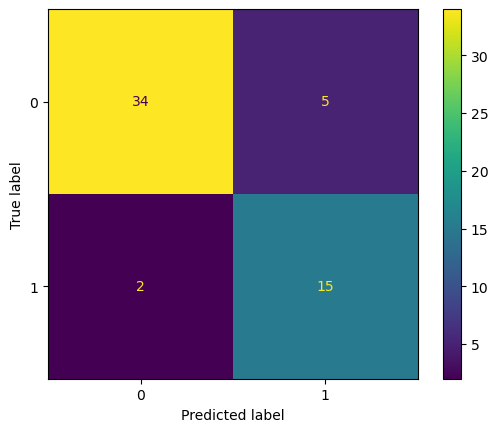

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_mat)

plot_confusion_matrix(log_reg, X_test_selected, y_test)
plt.show()

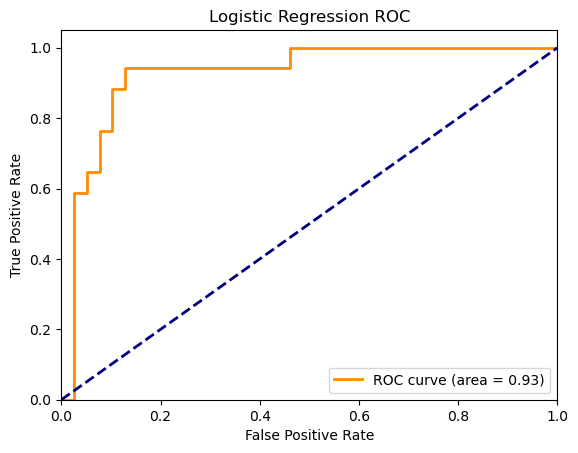

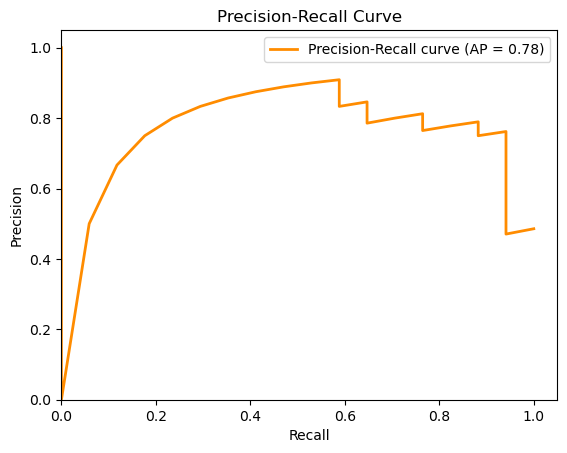

In [20]:
y_pred_proba = log_reg.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [25]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(kernel="linear", random_state=42)
rfe = RFECV(estimator=svc, step=1, cv=5, scoring="accuracy")
rfe.fit(X_train_scaled, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("Відібрані ознаки (RFE):", selected_features_rfe)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_selected = rfe.transform(X_train_resampled)
X_test_selected = rfe.transform(X_test_scaled)
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train_selected, y_train_resampled)

y_pred = svm_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точність моделі методу опорних векторів: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

cross_val_scores = cross_val_score(svm_model, X_train_selected, y_train_resampled, cv=5)
print("Кросс-валідація результатів моделі методу опорних векторів:", cross_val_scores)
print(f"Середня точність кросс-валідації: {cross_val_scores.mean() * 100:.2f}%")

Відібрані ознаки (RFE): Index(['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction',
       'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking',
       'time'],
      dtype='object')
Точність моделі методу опорних векторів: 89.29%
Precision: 78.95%
Recall: 88.24%
F1-міра: 83.33%
Кросс-валідація результатів моделі методу опорних векторів: [0.66129032 0.79032258 0.85483871 0.87096774 0.80645161]
Середня точність кросс-валідації: 79.68%


Confusion matrix:
[[35  4]
 [ 2 15]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


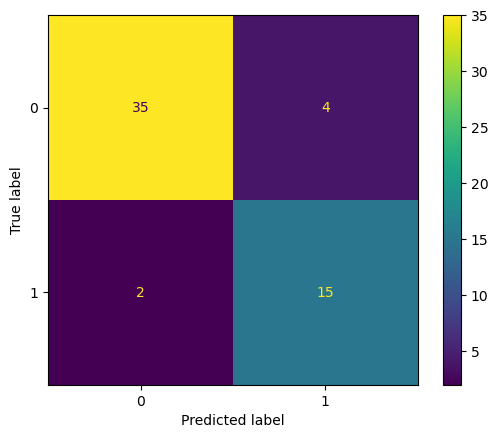

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_mat)

plot_confusion_matrix(svm_model, X_test_selected, y_test)
plt.show()

/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


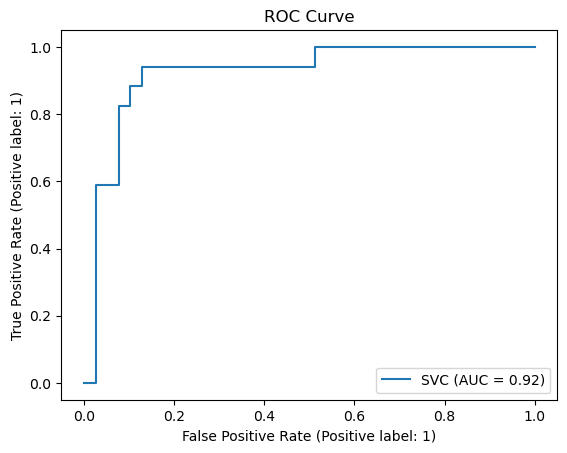

In [29]:
plot_roc_curve(svm_model, X_test_selected, y_test)
plt.title("ROC Curve")
plt.show()

In [32]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_resampled, y_train_resampled)

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точність моделі методом дерева рішень: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

# Кросс-валідація
cross_val_scores = cross_val_score(dt, X_train_resampled, y_train_resampled, cv=5)
print("Кросс-валідація результатів моделі методом дерева рішень:", cross_val_scores)
print(f"Середня точність кросс-валідації: {cross_val_scores.mean() * 100:.2f}%")

Точність моделі методом дерева рішень: 78.57%
Precision: 69.23%
Recall: 52.94%
F1-міра: 60.00%
Кросс-валідація результатів моделі методом дерева рішень: [0.74193548 0.82258065 0.80645161 0.85483871 0.82258065]
Середня точність кросс-валідації: 80.97%


Матриця неточностей:
 [[35  4]
 [ 8  9]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


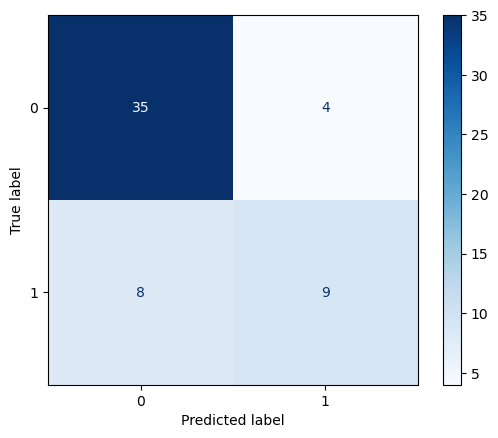

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Матриця неточностей:\n", conf_matrix)

plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

ROC-AUC: 0.71


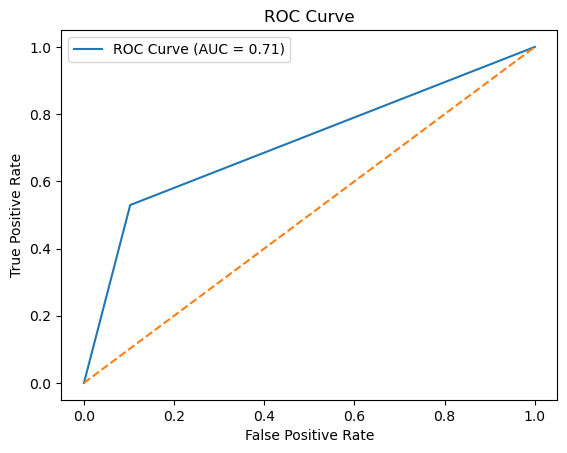

In [36]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [40]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
coef = np.abs(lasso.coef_)
selected_features_lasso = X.columns[coef > 1e-5]
print("Відібрані ознаки (Lasso):", selected_features_lasso)

smote = SMOTE(random_state=42)
X_train_selected = X_train.loc[:, selected_features_lasso]
X_test_selected = X_test.loc[:, selected_features_lasso]
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)

y_pred = knn.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точність моделі методу KNN: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

cv_scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5)
print("Кросс-валідація результатів моделі kNN:", cv_scores)
print(f"Середня точність кросс-валідації: {cv_scores.mean() * 100:.2f}%")

Відібрані ознаки (Lasso): Index(['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')
Точність моделі методу KNN: 71.43%
Precision: 52.17%
Recall: 70.59%
F1-міра: 60.00%
Кросс-валідація результатів моделі kNN: [0.67741935 0.83870968 0.82258065 0.88709677 0.82258065]
Середня точність кросс-валідації: 80.97%


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

Confusion Matrix:
 [[28 11]
 [ 5 12]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


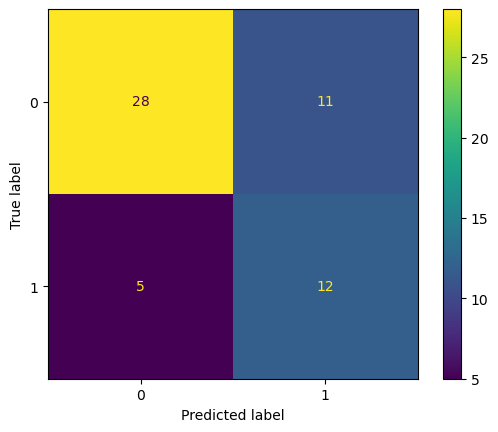

In [41]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plot_confusion_matrix(knn, X_test_selected, y_test)
plt.show()

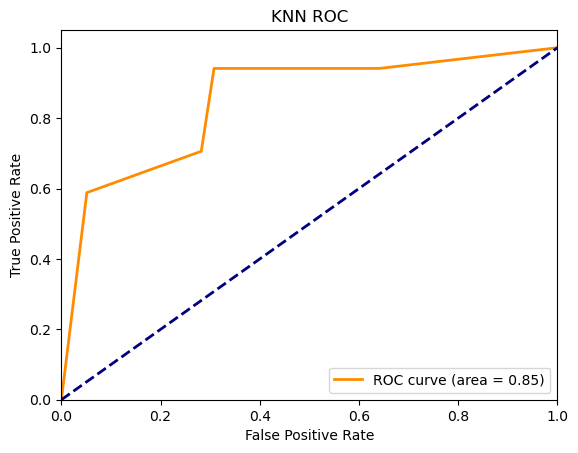

In [42]:
y_pred_proba = knn.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC')
plt.legend(loc="lower right")
plt.show()

In [45]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
coef = np.abs(lasso.coef_)
selected_features_lasso = X.columns[coef > 1e-5] 
print("Відібрані ознаки (Lasso):", selected_features_lasso)

smote = SMOTE(random_state=42)
X_train_selected = X_train.loc[:, selected_features_lasso]
X_test_selected = X_test.loc[:, selected_features_lasso]
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

gbdt = GradientBoostingClassifier(random_state=42)
gbdt.fit(X_train_resampled, y_train_resampled)

y_pred = gbdt.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Точність моделі GBDT: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

cv_scores = cross_val_score(gbdt, X_train_resampled, y_train_resampled, cv=5)
print(f"Кросс-валідація результатів моделі GBDT: {cv_scores}")
print(f"Середня точність кросс-валідації: {cv_scores.mean() * 100:.2f}%")

Відібрані ознаки (Lasso): Index(['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')
Точність моделі GBDT: 82.14%
Precision: 73.33%
Recall: 64.71%
F1-міра: 68.75%
Кросс-валідація результатів моделі GBDT: [0.75806452 0.90322581 0.85483871 0.90322581 0.91935484]
Середня точність кросс-валідації: 86.77%


Confusion matrix:
[[35  4]
 [ 6 11]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


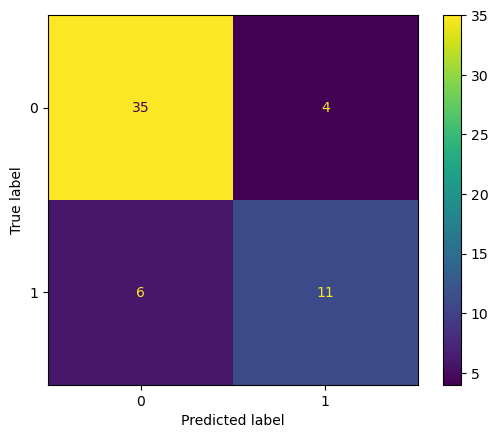

In [47]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_mat)

plot_confusion_matrix(gbdt, X_test_selected, y_test)
plt.show()

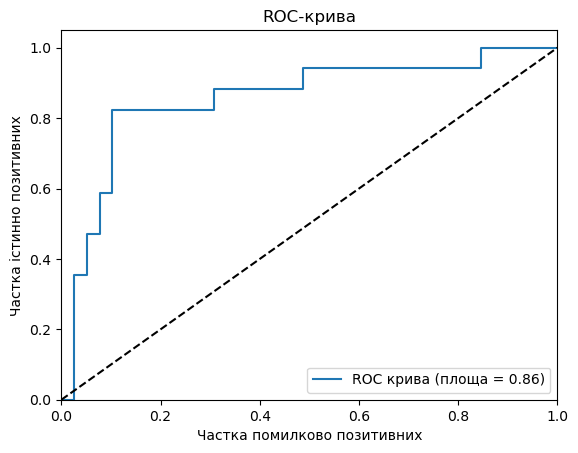

In [48]:
y_pred_proba = gbdt.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC крива (площа = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Частка помилково позитивних')
plt.ylabel('Частка істинно позитивних')
plt.title('ROC-крива')
plt.legend(loc="lower right")
plt.show()

In [55]:
X = data_no_outliers.drop(columns=['HEART_DISEASE'])
y = data_no_outliers['HEART_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=8, step=1)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

selected_features_rfe = X.columns[rfe.support_]
print("Відібрані ознаки (RFE):", selected_features_rfe)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rfe, y_train)

rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точність моделі Random Forest: {accuracy * 100:.2f}%")

print("\nМетрики класифікації:")
print(classification_report(y_test, y_pred))
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("\nТочність кросс-валідації для моделі Random Forest:")
print(cv_scores)
print(f"Середня точність кросс-валідації: {np.mean(cv_scores) * 100:.2f}%")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-міра: {f1 * 100:.2f}%")

Відібрані ознаки (RFE): Index(['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction',
       'platelets', 'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')
Точність моделі Random Forest: 87.50%

Метрики класифікації:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        39
           1       0.81      0.76      0.79        17

    accuracy                           0.88        56
   macro avg       0.86      0.84      0.85        56
weighted avg       0.87      0.88      0.87        56


Точність кросс-валідації для моделі Random Forest:
[0.83870968 0.85483871 0.91935484 0.96774194 0.90322581]
Середня точність кросс-валідації: 89.68%
Precision: 81.25%
Recall: 76.47%
F1-міра: 78.79%


Матриця помилок:
[[36  3]
 [ 4 13]]


/Users/vladsyrotiuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


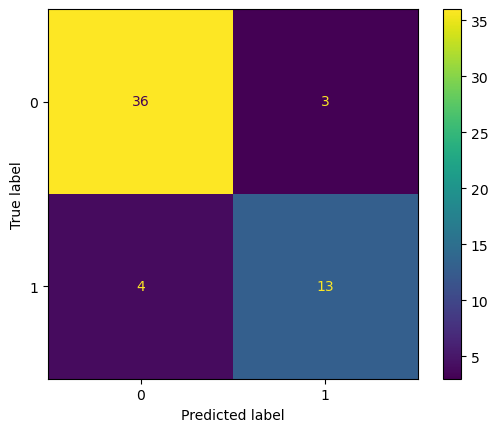

In [56]:
print("Матриця помилок:")
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(rf, X_test_rfe, y_test)
plt.show()

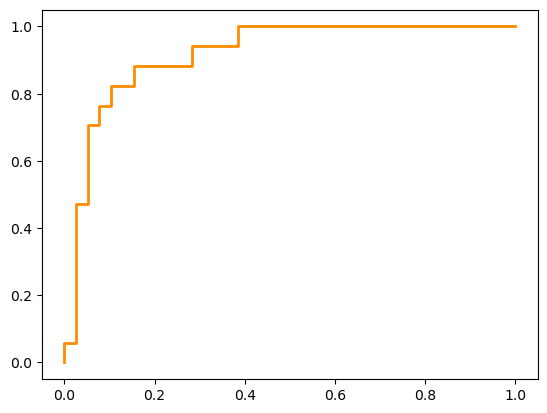

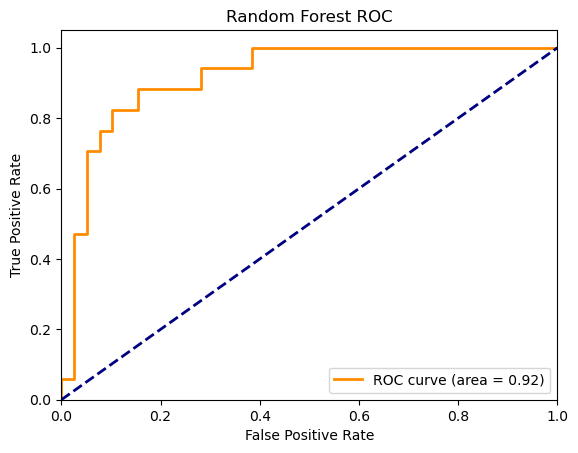

In [57]:
y_pred_proba = rf.predict_proba(X_test_rfe)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

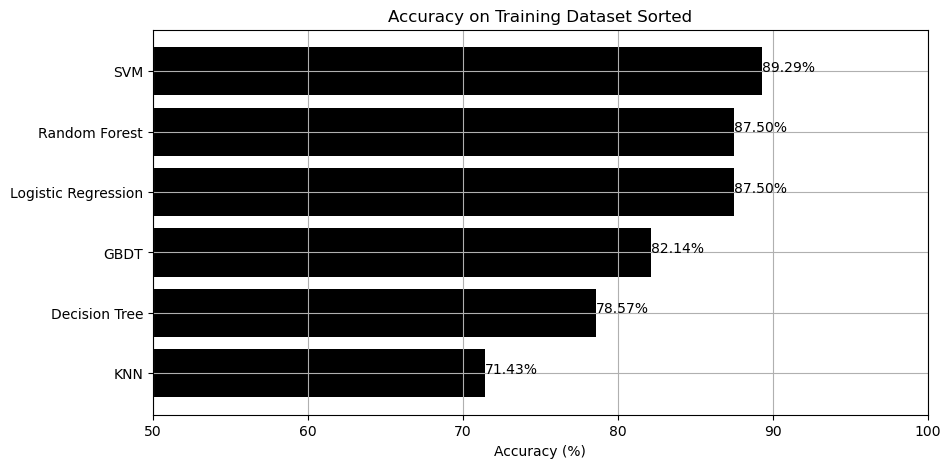

In [59]:
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'GBDT', 'Random Forest']
accuracy = [87.50, 89.29, 78.57, 71.43, 82.14, 87.50]

pairs = list(zip(accuracy, models))
sorted_pairs = sorted(pairs, reverse=False)

sorted_accuracy, sorted_models = zip(*sorted_pairs)
plt.figure(figsize=(10, 5))
plt.barh(sorted_models, sorted_accuracy, color='black')
plt.xlabel('Accuracy (%)')
plt.title('Accuracy on Training Dataset Sorted')
plt.xlim(50, 100)
plt.grid(True)

for index, value in enumerate(sorted_accuracy):
    plt.text(value, index, f'{value:.2f}%')

plt.show()

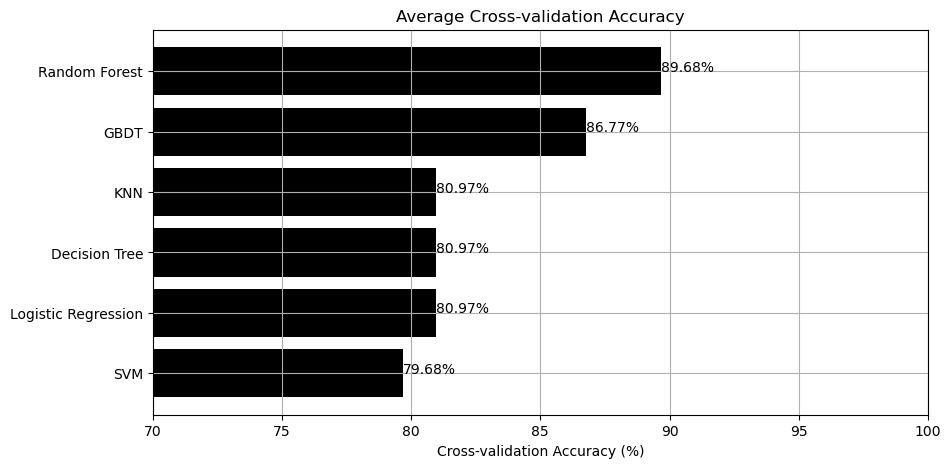

In [60]:
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'GBDT', 'Random Forest']
cross_val_accuracy = [80.97, 79.68, 80.97, 80.97, 86.77, 89.68]

models_accuracy = list(zip(models, cross_val_accuracy))

models_accuracy.sort(key=lambda x: x[1], reverse=False)
models_sorted, cross_val_accuracy_sorted = zip(*models_accuracy)
plt.figure(figsize=(10, 5))
plt.barh(models_sorted, cross_val_accuracy_sorted, color='black')
plt.xlabel('Cross-validation Accuracy (%)')
plt.title('Average Cross-validation Accuracy')
plt.xlim(70, 100)
plt.grid(True)

for index, value in enumerate(cross_val_accuracy_sorted):
    plt.text(value, index, str(value) + '%')

plt.show()

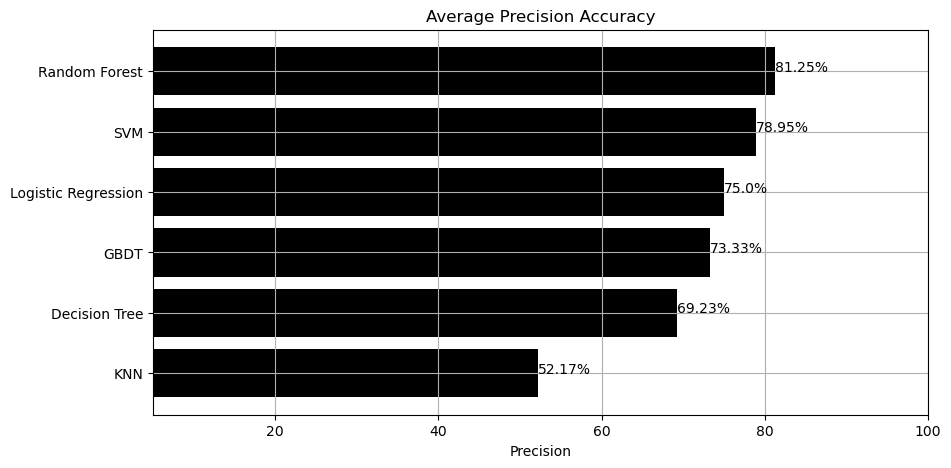

In [61]:
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'GBDT', 'Random Forest']
cross_val_accuracy = [75.00, 78.95, 69.23, 52.17, 73.33, 81.25]

models_accuracy = list(zip(models, cross_val_accuracy))
models_accuracy.sort(key=lambda x: x[1], reverse=False)
models_sorted, cross_val_accuracy_sorted = zip(*models_accuracy)

plt.figure(figsize=(10, 5))
plt.barh(models_sorted, cross_val_accuracy_sorted, color='black')
plt.xlabel('Precision')
plt.title('Average Precision Accuracy')
plt.xlim(5, 100)  
plt.grid(True)

for index, value in enumerate(cross_val_accuracy_sorted):
    plt.text(value, index, str(value) + '%')

plt.show()

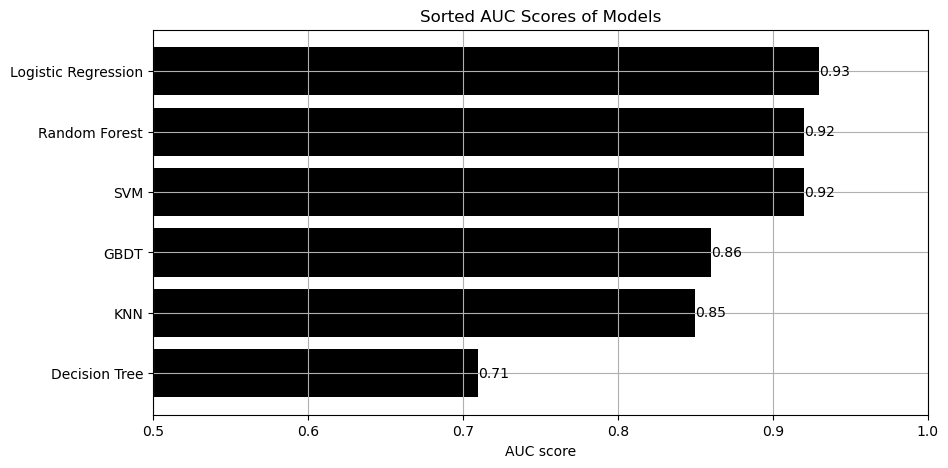

In [62]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'GBDT', 'Random Forest']
auc_scores = [0.93, 0.92, 0.71, 0.85, 0.86, 0.92]
models_auc = list(zip(models, auc_scores))

models_auc.sort(key=lambda x: x[1], reverse=False)

models_sorted, auc_scores_sorted = zip(*models_auc)

plt.figure(figsize=(10, 5))
plt.barh(models_sorted, auc_scores_sorted, color='black')
plt.xlabel('AUC score')
plt.title('Sorted AUC Scores of Models')
plt.xlim(0.5, 1)  
plt.grid(True)

for index, value in enumerate(auc_scores_sorted):
    plt.text(value, index, str(value), va='center')

plt.show()

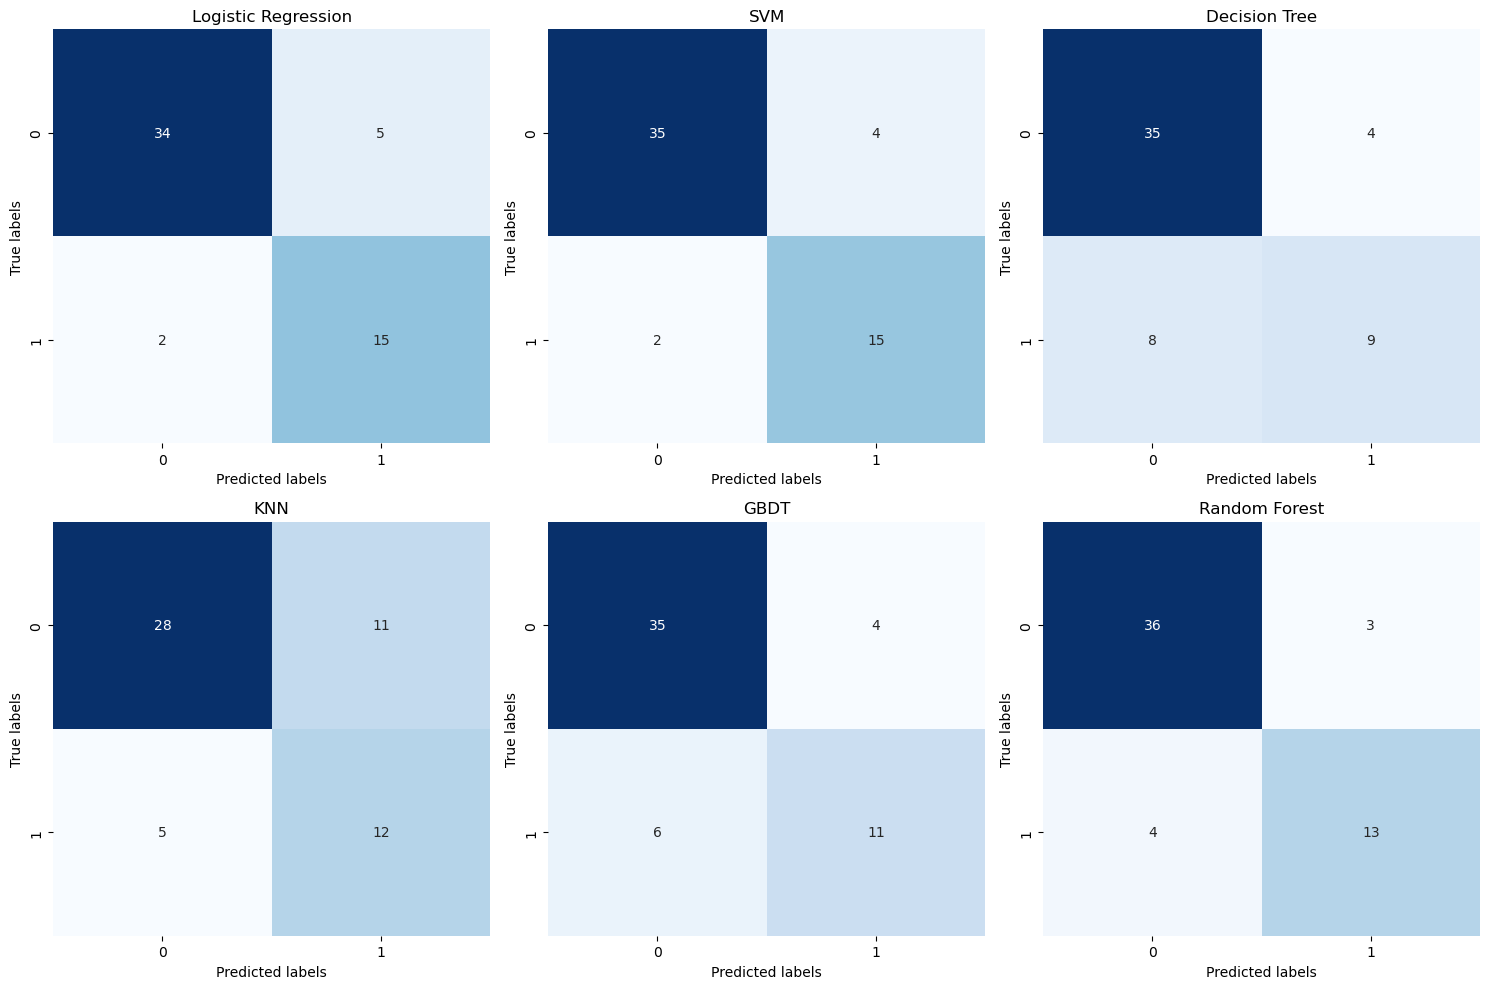

In [63]:
cm_lr = np.array([[34, 5], [2, 15]])
cm_svm = np.array([[35, 4], [2, 15]])
cm_dt = np.array([[35, 4], [8, 9]])
cm_knn = np.array([[28, 11], [5, 12]])
cm_gbdt = np.array([[35, 4], [6, 11]])
cm_rf = np.array([[36, 3], [4, 13]])

models = [('Logistic Regression', cm_lr),
          ('SVM', cm_svm),
          ('Decision Tree', cm_dt),
          ('KNN', cm_knn),
          ('GBDT', cm_gbdt),
          ('Random Forest', cm_rf)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (model, cm) in zip(axes.ravel(), models):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_title(model)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


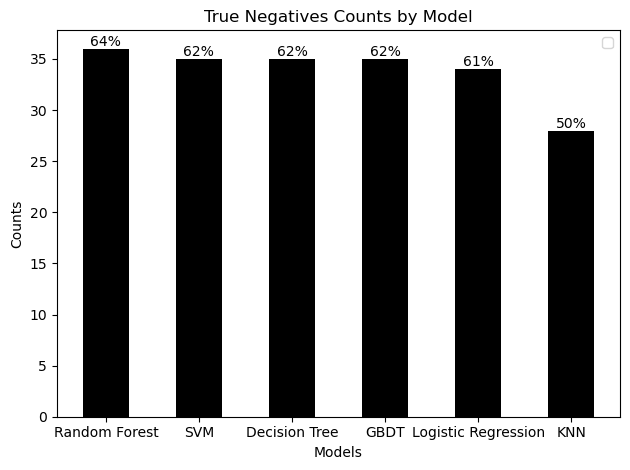

In [64]:
models = [('Logistic Regression', cm_lr),
          ('SVM', cm_svm),
          ('Decision Tree', cm_dt),
          ('KNN', cm_knn),
          ('GBDT', cm_gbdt),
          ('Random Forest', cm_rf)]


models.sort(key=lambda x: x[1][0, 0], reverse=True)
index = np.arange(len(models))
bar_width = 0.5
fig, ax = plt.subplots()

bars = ax.bar(index, [cm[0,0] for _, cm in models], bar_width, color='black')

ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('True Negatives Counts by Model')
ax.set_xticks(index)
ax.set_xticklabels([model for model, _ in models])
ax.legend()

for bar, (_, cm) in zip(bars, models):
    height = bar.get_height()
    total = np.sum(cm)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            '{0:.0%}'.format(height / total),
            ha='center', va='bottom')

fig.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


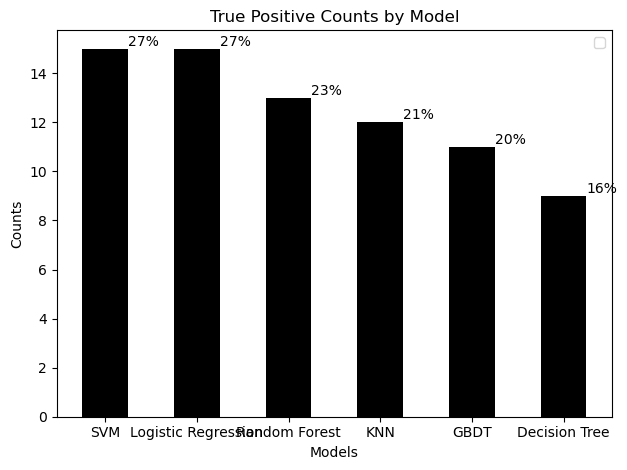

In [67]:
models.sort(key=lambda x: x[1][1, 1], reverse=True)
index = np.arange(len(models))
bar_width = 0.5

fig, ax = plt.subplots()

bars = ax.bar(index, [cm[1,1] for _, cm in models], bar_width, color='black')

ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('True Positive Counts by Model')
ax.set_xticks(index)
ax.set_xticklabels([model for model, _ in models])
ax.legend()
for bar, (_, cm) in zip(bars, models):
    height = bar.get_height()
    total = np.sum(cm)
    ax.text(bar.get_x() + bar.get_width(), height,
            '{0:.0%}'.format(height / total),
            ha='left', va='bottom')

fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


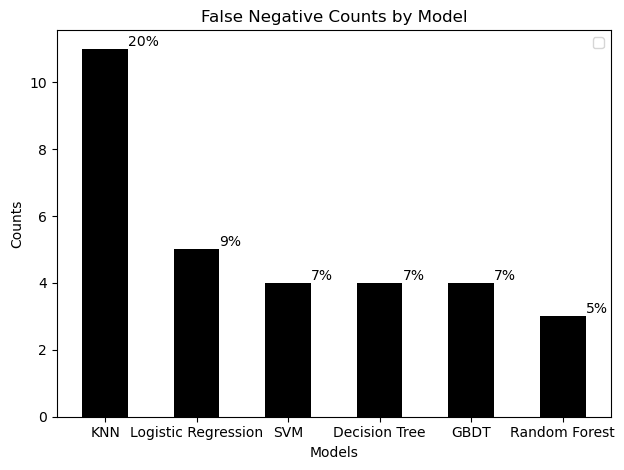

In [68]:
models = [('Logistic Regression', cm_lr),
          ('SVM', cm_svm),
          ('Decision Tree', cm_dt),
          ('KNN', cm_knn),
          ('GBDT', cm_gbdt),
          ('Random Forest', cm_rf)]

models.sort(key=lambda x: x[1][0, 1], reverse=True)

index = np.arange(len(models))
bar_width = 0.5

fig, ax = plt.subplots()

bars = ax.bar(index, [cm[0,1] for _, cm in models], bar_width, color='black')

ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('False Negative Counts by Model')
ax.set_xticks(index)
ax.set_xticklabels([model for model, _ in models])
ax.legend()

for bar, (_, cm) in zip(bars, models):
    height = bar.get_height()
    total = np.sum(cm)
    ax.text(bar.get_x() + bar.get_width(), height,
            '{0:.0%}'.format(height / total),
            ha='left', va='bottom')

fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


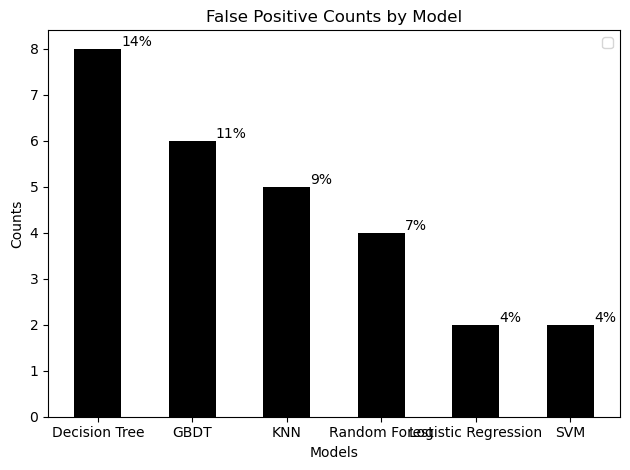

In [69]:
models = [('Logistic Regression', cm_lr),
          ('SVM', cm_svm),
          ('Decision Tree', cm_dt),
          ('KNN', cm_knn),
          ('GBDT', cm_gbdt),
          ('Random Forest', cm_rf)]

models.sort(key=lambda x: x[1][1, 0], reverse=True)

index = np.arange(len(models))
bar_width = 0.5

fig, ax = plt.subplots()

bars = ax.bar(index, [cm[1,0] for _, cm in models], bar_width, color='black')

ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('False Positive Counts by Model')
ax.set_xticks(index)
ax.set_xticklabels([model for model, _ in models])
ax.legend()

# Додавання відсотків на стовпці
for bar, (_, cm) in zip(bars, models):
    height = bar.get_height()
    total = np.sum(cm)
    ax.text(bar.get_x() + bar.get_width(), height,
            '{0:.0%}'.format(height / total),
            ha='left', va='bottom')

fig.tight_layout()
plt.show()


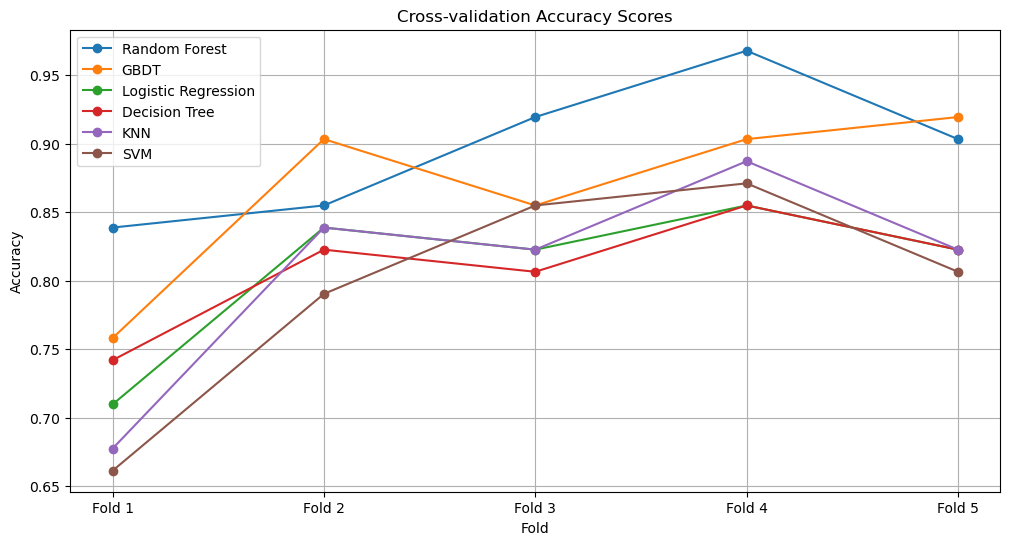

In [70]:
cv_scores = {
    'Logistic Regression': [0.70967742, 0.83870968, 0.82258065, 0.85483871, 0.82258065],
    'SVM': [0.66129032, 0.79032258, 0.85483871, 0.87096774, 0.80645161],
    'Decision Tree': [0.74193548, 0.82258065, 0.80645161, 0.85483871, 0.82258065],
    'KNN': [0.67741935, 0.83870968, 0.82258065, 0.88709677, 0.82258065],
    'GBDT': [0.75806452, 0.90322581, 0.85483871, 0.90322581, 0.91935484],
    'Random Forest': [0.83870968, 0.85483871, 0.91935484, 0.96774194, 0.90322581],
}

models_avg_scores = [(model, np.mean(scores)) for model, scores in cv_scores.items()]
models_avg_scores.sort(key=lambda x: x[1], reverse=True)
models_sorted, _ = zip(*models_avg_scores)
plt.figure(figsize=(12, 6))
for model in models_sorted:
    plt.plot(cv_scores[model], '-o', label=model)

plt.title('Cross-validation Accuracy Scores')
plt.xlabel('Fold')
plt.xticks(range(5), [f'Fold {i+1}' for i in range(5)])
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

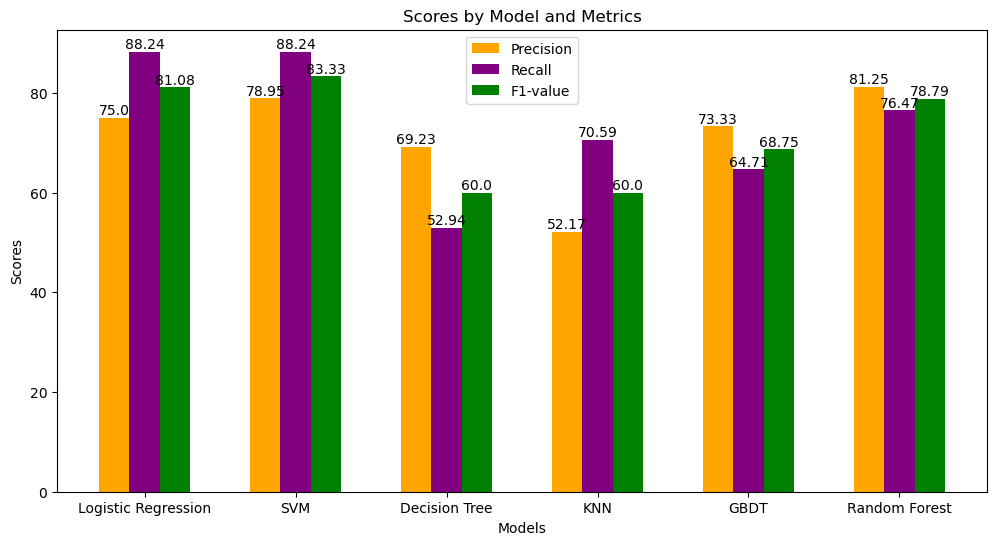

In [73]:
metrics_scores = {
    'Logistic Regression': {'Precision': 75.00, 'Recall': 88.24, 'F1-value': 81.08},
    'SVM': {'Precision': 78.95, 'Recall': 88.24, 'F1-value': 83.33},
    'Decision Tree': {'Precision': 69.23, 'Recall': 52.94, 'F1-value': 60.00},
    'KNN': {'Precision': 52.17, 'Recall': 70.59, 'F1-value': 60.00},
    'GBDT': {'Precision': 73.33, 'Recall': 64.71, 'F1-value': 68.75},
    'Random Forest': {'Precision': 81.25, 'Recall': 76.47, 'F1-value': 78.79}
}

fig, ax = plt.subplots(figsize=(12, 6))

index = np.arange(len(metrics_scores))
bar_width = 0.2

colors = ['orange', 'purple', 'green']
for i, metric in enumerate(['Precision', 'Recall', 'F1-value']):
    bars = ax.bar(index + i * bar_width, [model[metric] for model in metrics_scores.values()], bar_width, label=metric, color=colors[i])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics_scores.keys())
ax.legend()

plt.show()